# Analisis de la serie de tiempo de Precipitaciones Para el modelo ARIMA
Con este reporte se rpetende tener un analisis completo para determinar la calidad de la informacion y asi pider utilizar los datos para encontrar correlacion y analisis de la serie temporal, con la finalidad de crear un modelo predictivo para imputar sesgos.

In [1]:
from utils.utils import get_df_serie_temporal, agregar_columna_mes, categorize_precipitation, reshample_time_serie, describe_historical_serie, autocorrelacion
from graphics_utils.express import fig_boxplot, fig_lineplot, fig_pie_month, fig_pie, fig_boxplot_category, fig_histogram
from statistics_utils.eda.timeseries import decompose_time_series, correlation
#from figuras import combined_figures
from api_somo import fetch_qf
#from imputations import imputar_knn
from graphics_utils.go import multi_scatter, multi_boxplot, multi_line, autocorrelogram, arrange_figures_in_subplots
import kaleido
import ephem
import numpy as np
import pandas as pd

In [2]:
from api_somo import DataFetcher, fetch_qf 
import logging

# Setting up logging for the main script
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

api_url = "http://127.0.0.1:8000/database/filter-serie/"
params = {
    "station_name": "tumaco",
    "variable_name": "Precipitación acumulada",
    "processing_level_name": "Control de calidad",
    "start_date":"2009-01-01",
    "end_date":"2012-12-31"
    }

try:
    # 1. Fetch and process the data
    insitu = DataFetcher.fetch_and_process_data(api_url, params)

    if insitu.empty:
        raise ValueError("The historical series is empty.")

    # Additional processing with the historical series
    logger.info(f"Fetched historical series: {insitu.head(0)}")

except Exception as e:
    logger.error(f"Error fetching historical series: {e}")


display(insitu)

INFO:api_somo:Sending request to http://127.0.0.1:8000/database/filter-serie/ with parameters: {'station_name': 'tumaco', 'variable_name': 'Precipitación acumulada', 'processing_level_name': 'Control de calidad', 'start_date': '2009-01-01', 'end_date': '2012-12-31'}
INFO:api_somo:Original columns: ['date_time', 'sensor_data', 'quality_flag', 'latitude', 'longitude']
INFO:api_somo:Columns after renaming: ['timestamp', 'value', 'qf', 'latitude', 'longitude']
INFO:api_somo:Timestamp conversion and indexing complete.
INFO:__main__:Fetched historical series: Empty DataFrame
Columns: [value, qf, latitude, longitude]
Index: []


,value,qf,latitude,longitude
timestamp,,,,
2009-02-01 05:10:00+00:00,0.0,1,1.82011,-78.72871
2009-02-01 05:20:00+00:00,0.0,1,1.82011,-78.72871
2009-02-01 05:30:00+00:00,0.0,1,1.82011,-78.72871
2009-02-01 05:40:00+00:00,0.0,1,1.82011,-78.72871
2009-02-01 05:50:00+00:00,0.0,1,1.82011,-78.72871
...,...,...,...,...
2012-12-31 04:20:00+00:00,0.1,1,1.82011,-78.72871
2012-12-31 04:30:00+00:00,0.0,1,1.82011,-78.72871
2012-12-31 04:40:00+00:00,0.1,1,1.82011,-78.72871


In [3]:

print(insitu)
pie_fig = fig_pie_month(insitu,params)
pie_fig.show()

                           value  qf  latitude  longitude
timestamp                                                
2009-02-01 05:10:00+00:00    0.0   1   1.82011  -78.72871
2009-02-01 05:20:00+00:00    0.0   1   1.82011  -78.72871
2009-02-01 05:30:00+00:00    0.0   1   1.82011  -78.72871
2009-02-01 05:40:00+00:00    0.0   1   1.82011  -78.72871
2009-02-01 05:50:00+00:00    0.0   1   1.82011  -78.72871
...                          ...  ..       ...        ...
2012-12-31 04:20:00+00:00    0.1   1   1.82011  -78.72871
2012-12-31 04:30:00+00:00    0.0   1   1.82011  -78.72871
2012-12-31 04:40:00+00:00    0.1   1   1.82011  -78.72871
2012-12-31 04:50:00+00:00    0.0   1   1.82011  -78.72871
2012-12-31 05:00:00+00:00    0.0   1   1.82011  -78.72871

[205776 rows x 4 columns]


# Calida de la serie de riempo por meses
Esta grafica muestra el porcentaje de datos buenos por mes que tiene la serie en cuestion, con el fin de analizar los posibles errores asociados a la metodologia.

value         176
qf              0
latitude        0
longitude       0
month           0
year            0
fase_lunar      0
dtype: int64


,value,qf,latitude,longitude,month,year,fase_lunar
timestamp,,,,,,,
2009-02-01,0.0,1,1.82011,-78.72871,2,2009,29.393515
2009-02-02,0.7,1,1.82011,-78.72871,2,2009,39.577026
2009-02-03,23.3,1,1.82011,-78.72871,2,2009,50.491077
2009-02-04,0.0,1,1.82011,-78.72871,2,2009,61.644176
2009-02-05,0.0,1,1.82011,-78.72871,2,2009,72.452530


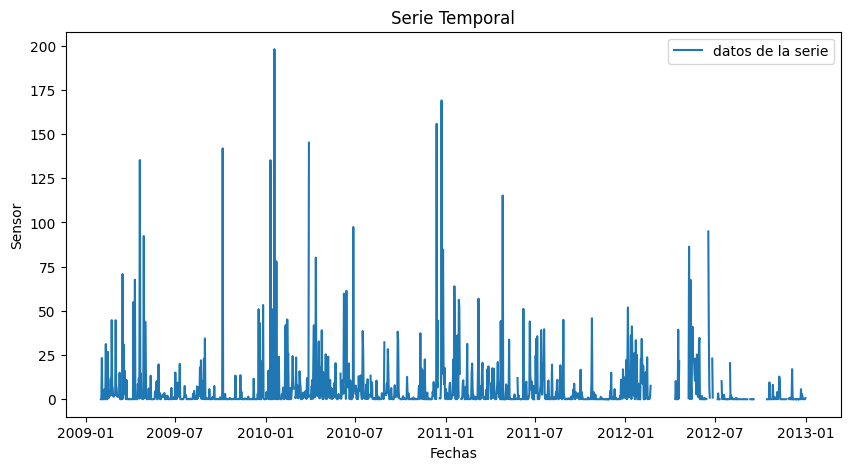

In [4]:
# PRE-PROCESAMIENTO DE LAS SERIES
insitu.loc[insitu['qf'] != 1, 'value'] = np.nan
#insitu = categorize_precipitation(insitu, params)
diario = reshample_time_serie(insitu, 'D', 'sum')
diario.loc[diario['qf'] != 1, 'value'] = np.nan
from cProfile import label
import ephem
import pandas as pd

# Asegúrate de que el índice sea de tipo datetime
diario.index = pd.to_datetime(diario.index)

# Calcular las fases lunares
fases_lunares = []
for fecha in diario.index:
    moon = ephem.Moon()
    moon.compute(fecha.strftime('%Y-%m-%d'))  # Convertir a formato compatible con ephem
    fases_lunares.append(moon.phase)

# Agregar fase lunar al DataFrame
diario['fase_lunar'] = fases_lunares

import matplotlib.pyplot as plt 

plt.figure(figsize=(10,5))
plt.plot(diario.index, diario['value'], label= 'datos de la serie')
plt.xlabel('Fechas')
plt.ylabel('Sensor')
plt.title('Serie Temporal')
plt.legend()

# Mostrar el resultado
print(diario.isna().sum())
display(diario.head())


# Distribucion de la precipitacion en el año
Aqui se puede analizar cual fue el comportameinto estadistico de la serie temporal, vemos las tendencias y estacionallidades.

In [5]:
from statistics_utils.eda.timeseries import test_stationarity
test_stationarity(diario['value'])

MissingDataError: exog contains inf or nans

In [6]:
# Calcular la primera diferenciación
diferenciada = diario.copy()
diferenciada['value'] = diario['value'].diff()  # Calcular la diferencia
diferenciada = diferenciada.dropna(subset=['value'])  # Eliminar filas con NaN en 'value'
# Validar que no hay NaN o Inf en la columna 'value'
diferenciada = diferenciada[~diferenciada['value'].isin([np.inf, -np.inf])]  # Eliminar Inf
# Prueba de estacionariedad
test_stationarity(diferenciada['value'])


Resultados de la Prueba de Dickey-Fuller Aumentada:
Estadístico de Prueba: -12.783350364567848
Valor P: 7.334989673840612e-24
Número de Retardos Usados: 24
Número de Observaciones: 1404
Valores Críticos:
  1%: -3.4350161653396736
  5%: -2.863600780613854
  10%: -2.567867151504452

La serie es estacionaria (se rechaza H₀).


In [7]:

# Segunda diferenciación (doble diferenciación)
diferenciada_2 = diario.copy()
diferenciada_2['value'] = diferenciada['value'].diff()
diferenciada_2 = diferenciada_2.dropna(subset=['value'])  # Eliminar filas con NaN en 'value'
# Validar que no hay NaN o Inf en la columna 'value'
diferenciada_2 = diferenciada_2[~diferenciada_2['value'].isin([np.inf, -np.inf])]  # Eliminar Inf
# Prueba de estacionariedad
test_stationarity(diferenciada_2['value'])


Resultados de la Prueba de Dickey-Fuller Aumentada:
Estadístico de Prueba: -15.07273733902189
Valor P: 8.677615055330797e-28
Número de Retardos Usados: 24
Número de Observaciones: 1403
Valores Críticos:
  1%: -3.435019497302916
  5%: -2.863602251005175
  10%: -2.567867934524786

La serie es estacionaria (se rechaza H₀).


In [8]:
import figuras


line = multi_line(Original=diario['value'], Diferencia1=diferenciada['value'], Diferencia2 = diferenciada_2['value'])
histograma = fig_histogram(diario, params)
histograma_dif = fig_histogram(diferenciada, params)
histograma_dif2 = fig_histogram(diferenciada_2, params)
figuras_h={
    'line':line,
    'histograma': histograma,
    'histograma_dif':histograma_dif,
    'histograma_dif2':histograma_dif2
}
fig = arrange_figures_in_subplots(list(figuras_h.values()), 2, 2)
fig.show()

In [9]:
# Calcular autocorrelaciones
corr = correlation(diario['value'], lags=90)
corr_dif1 = correlation(diferenciada['value'], lags=30)
corr_dif2 = correlation(diferenciada_2['value'], lags=30)

# Crear los autocorrelogramas
corr_original = autocorrelogram(corr, lags=30)
correlo_dif1 = autocorrelogram(corr_dif1, lags=30)
correlo_dif2 = autocorrelogram(corr_dif2, lags=30)

# Agrupar las figuras en un diccionario
figuras = {
    'Original': corr_original,
    'Diff1': correlo_dif1,
    'Diff2': correlo_dif2
}

# Organizar las figuras en subplots
corr_fig = arrange_figures_in_subplots(list(figuras.values()), 2, 2)
corr_fig.show()


d:\master BigData\01 proyecto final\codigos\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

d:\master BigData\01 proyecto final\codigos\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

d:\master BigData\01 proyecto final\codigos\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



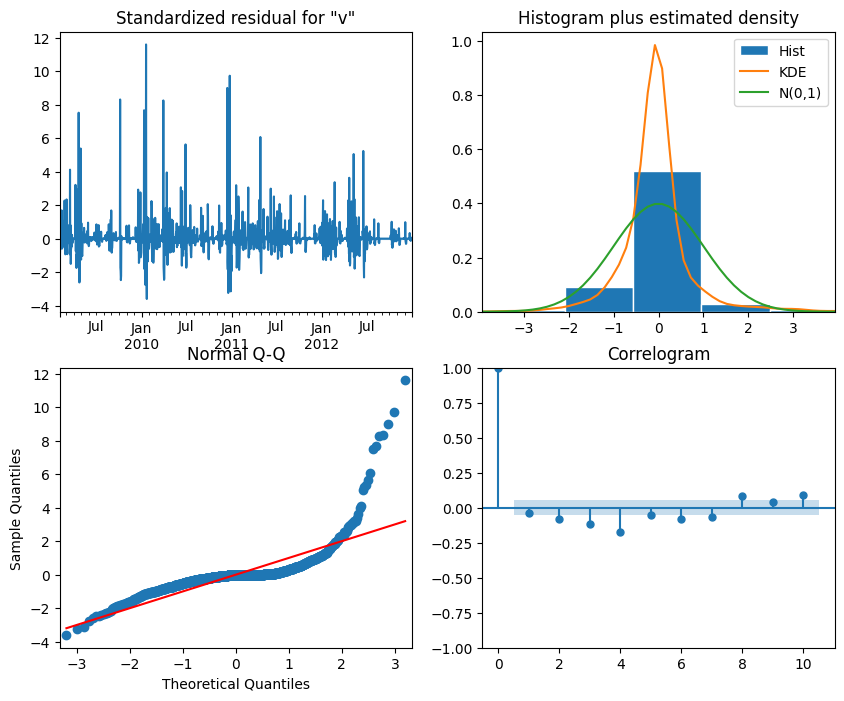

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 1429
Model:                 ARIMA(3, 1, 1)   Log Likelihood               -6081.976
Date:                Wed, 05 Feb 2025   AIC                          12173.952
Time:                        11:48:15   BIC                          12200.272
Sample:                    02-02-2009   HQIC                         12183.782
                         - 12-31-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7839      0.017    -44.822      0.000      -0.818      -0.750
ar.L2         -0.5567      0.018    -30.658      0.000      -0.592      -0.521
ar.L3         -0.2635      0.014    -18.436      0.0

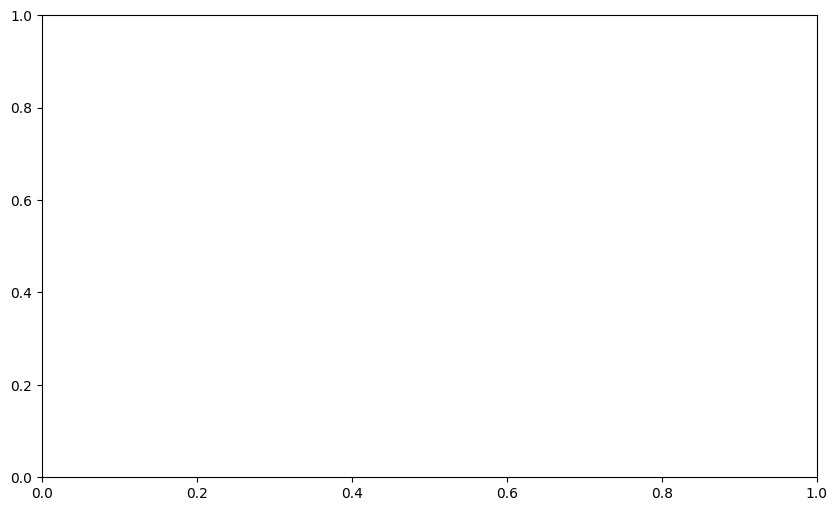

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Parámetros ARIMA
p = 3
d = 1
q = 1

# Ajustar modelo ARIMA
model = ARIMA(diferenciada['value'], order=(p, d, q))
result = model.fit()

# Graficar diagnóstico
result.plot_diagnostics(figsize=(10, 8))
plt.show()

# Realizar predicciones dentro de la muestra (in-sample)
predictions = result.predict(start=d, end=len(diferenciada['value']) - 1)

# Graficar los datos originales y las predicciones
fig, ax = plt.subplots(figsize=(10, 6))
pred_fig = multi_line(Original=diario['value'],Entrenamiento= abs(predictions))

pred_fig.show()

# Resumen del modelo
print(result.summary())


In [11]:
import statsmodels.api as sm
sm.stats.acorr_ljungbox(result.resid, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,118.394453,1.071027e-20


In [12]:
#Los valores ajustados del modelo, es decir, las predicciones del modelo para los datos de entrenamiento.
entrenamiento = pd.DataFrame(result.fittedvalues)
entrenamiento.columns = ['value']
fig_ent = multi_line(Original= diario['value'], Entrenamiento = entrenamiento['value'])
fig_ent.show()


In [13]:

from statsmodels.tsa.arima.model import ARIMA
p=1
d=1
q=2


# Ajustar modelo ARIMA
model = ARIMA(diario['value'], order=(p, d, q))
result = model.fit()

# Resumen del modelo
print(result.summary())

# Predicciones
predicciones = result.forecast(steps=10)
print(predicciones)

d:\master BigData\01 proyecto final\codigos\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

d:\master BigData\01 proyecto final\codigos\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

d:\master BigData\01 proyecto final\codigos\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 1430
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -5980.500
Date:                Wed, 05 Feb 2025   AIC                          11969.000
Time:                        11:48:16   BIC                          11990.059
Sample:                    02-01-2009   HQIC                         11976.865
                         - 12-31-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5239      2.325     -0.225      0.822      -5.080       4.032
ma.L1         -0.4259      2.301     -0.185      0.853      -4.936       4.084
ma.L2         -0.5070      2.201     -0.230      0.8